In [1]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from numpy.fft import rfft, irfft, fft, ifft

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [30]:
#observation = "data/obs/56477.53_AO_1400"
observation = "data/obs/56412.76_GBT_1400"
#observation = "data/obs/56180.35_AO_1400"
#observation = "data/obs/56207.39_GBT_1400"
#observation = "data/obs/56214.26_GBT_1400"
template = "template-work/56412.76_GBT_1400.rmset.scrunch.sm"
#template = "template-work/56736.85_AO_1400.profile.psrsmooth"
processing_name = "singlefrequency"
obsname = observation.split("/")[-1]

In [32]:
gtp_data = None
gtp_weights = None
for f in sorted(glob(join(observation,processing_name,"zap_*.ar")))[::-1]:
    F = psrchive.Archive_load(f)
    F.tscrunch()
    F.dedisperse()
    F.remove_baseline()
    F.convert_state('Stokes')
    d = F.get_data()[0,:,:,:]
    w = F.get_weights()[0,:]
    if gtp_data is None:
        gtp_data = d
        gtp_weights = w
    else:
        gtp_data += d
        gtp_weights += w

[ 1.57497835  1.61208773  1.64822054 ...,  1.47634554  1.50759554
  1.5398221 ]


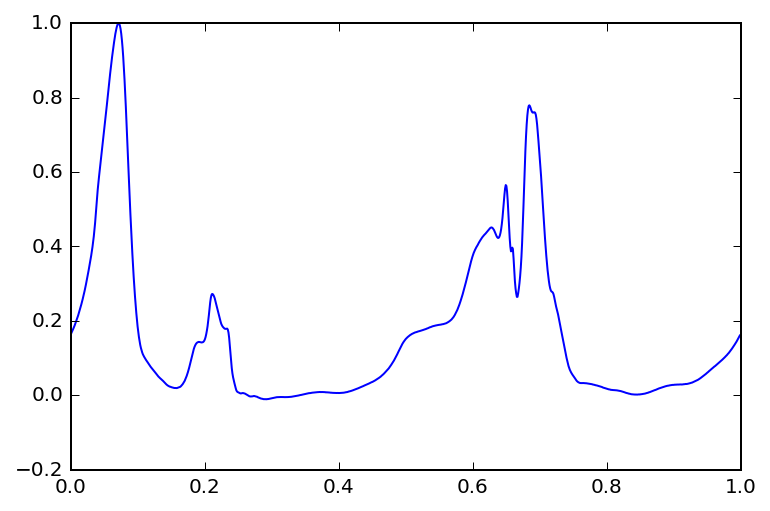

In [31]:
T = psrchive.Archive_load(template)
T.dedisperse()
T.pscrunch()
T.remove_baseline()
t_values = T.get_data()[0,0,0,:]
print(t_values)
t_values = pipe.convert_template(t_values, gtp_data.shape[-1])
t_phases = np.linspace(0,1,len(t_values),endpoint=False)
t_values /= np.amax(t_values)
plt.plot(t_phases,t_values)

In [33]:
nchan = gtp_data.shape[1]
channel_edges = np.linspace(F.get_centre_frequency()-F.get_bandwidth()/2,
                            F.get_centre_frequency()+F.get_bandwidth()/2,
                            nchan+1)


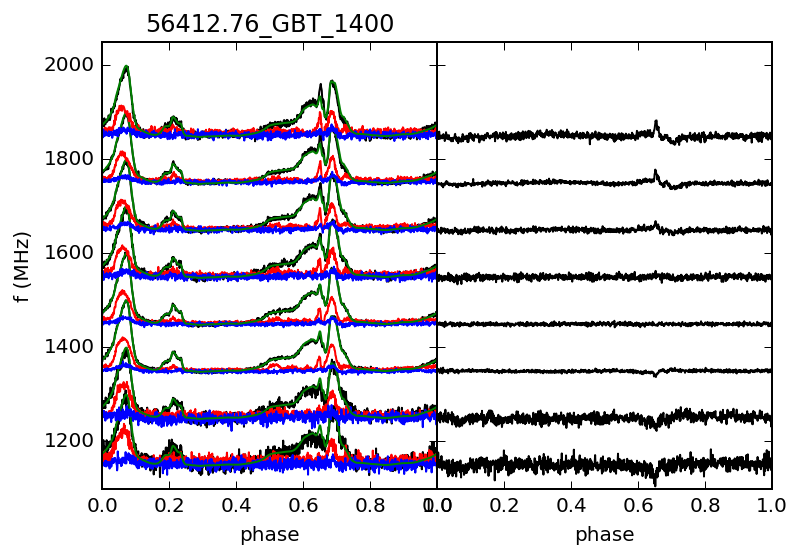

In [34]:
nbands = 8
ix = np.linspace(0,nchan,nbands+1).astype(int)
height_fac = 3
for i in range(nbands):
    d = np.sum(gtp_data[:,ix[i]:ix[i+1],:], axis=1)
    w = np.sum(gtp_weights[ix[i]:ix[i+1]])
    if w==0:
        continue
    prof = d/w
    f = (channel_edges[ix[i]]+channel_edges[ix[i+1]])/2
    bw = (channel_edges[ix[i+1]]-channel_edges[ix[i]])/2
    
    phase, amp, bg = align_scale_profile(prof[0], t_values)
    prof_fit = np.array([rotate_phase(prof[i], phase)*amp + bg for i in range(4)])
    lin = np.hypot(prof_fit[1],prof_fit[2])
    
    plt.subplot(121)
    plt.plot(t_phases, prof_fit[0]*bw*height_fac+f, color="k")
    plt.plot(t_phases, lin*bw*height_fac+f, color="r")
    plt.plot(t_phases, prof_fit[3]*bw*height_fac+f, color="b")
    plt.plot(t_phases, t_values*bw*height_fac+f, color="g")

    plt.subplot(122)
    plt.plot(t_phases, (prof_fit[0]-t_values)*bw*height_fac+f, color="k")

plt.subplot(121)
plt.xlabel("phase")
plt.ylabel("f (MHz)")
plt.ylim(np.amin(channel_edges),np.amax(channel_edges)+abs(height_fac*bw))
plt.title(obsname)
plt.subplot(122)
plt.ylim(np.amin(channel_edges),np.amax(channel_edges)+abs(height_fac*bw))
plt.tick_params(axis='y', labelleft='off')
plt.xlabel("phase")
plt.subplots_adjust(wspace=0)
plt.savefig("profile-variation-%s.pdf" % obsname)

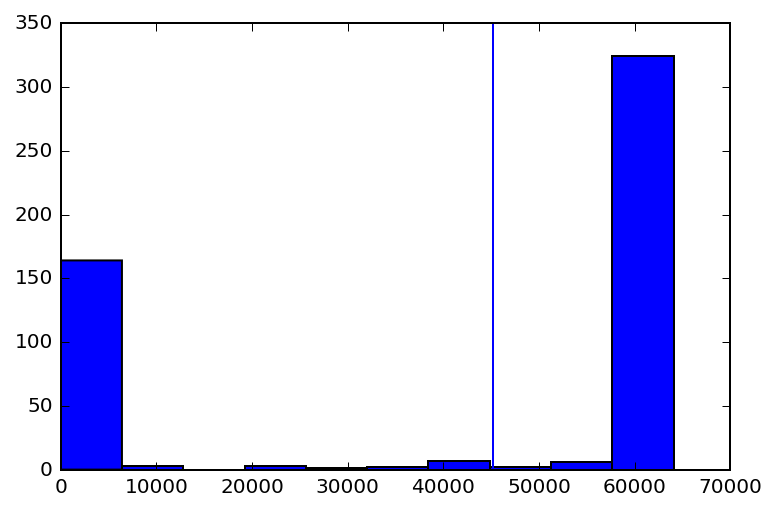

In [65]:
plt.hist(gtp_weights)
w_cut = np.percentile(gtp_weights[gtp_weights!=0], 5)
plt.axvline(w_cut)

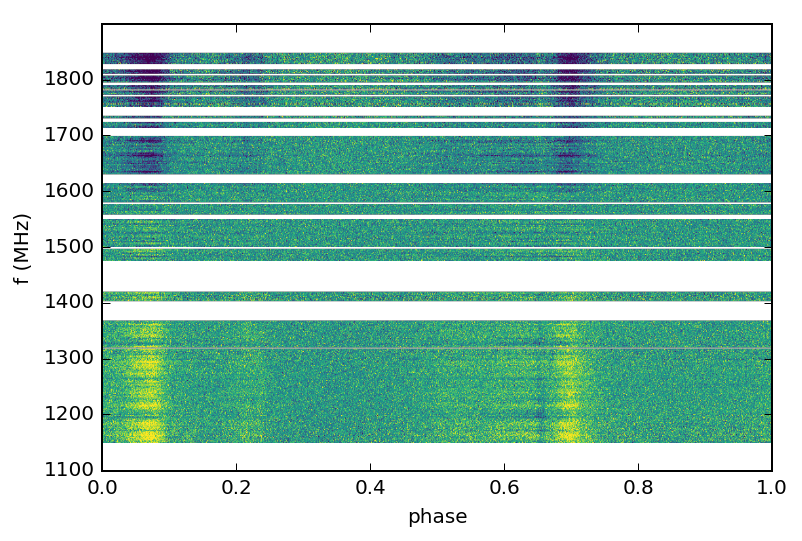

In [66]:
prof = np.average(gtp_data[0], weights=gtp_weights, axis=0)
x = prof.max()

im = np.ma.array(prof[None,:]-gtp_data[0])/x
im[gtp_weights<w_cut,:] = np.ma.masked
vmin, vmax = np.percentile(im.compressed(), [1,99])

plt.imshow(im, 
           extent=(0,1,channel_edges[0],channel_edges[-1]),
           vmin=vmin, vmax=vmax)
plt.gca().set_aspect('auto')
plt.xlabel("phase")
plt.ylabel("f (MHz)")
#plt.colorbar()
#plt.savefig("profile-variation-gtp.pdf")

In [42]:
channel_edges[0]

1099.21875

In [44]:
im.compressed?

array([-368.04312006,  115.01989006])

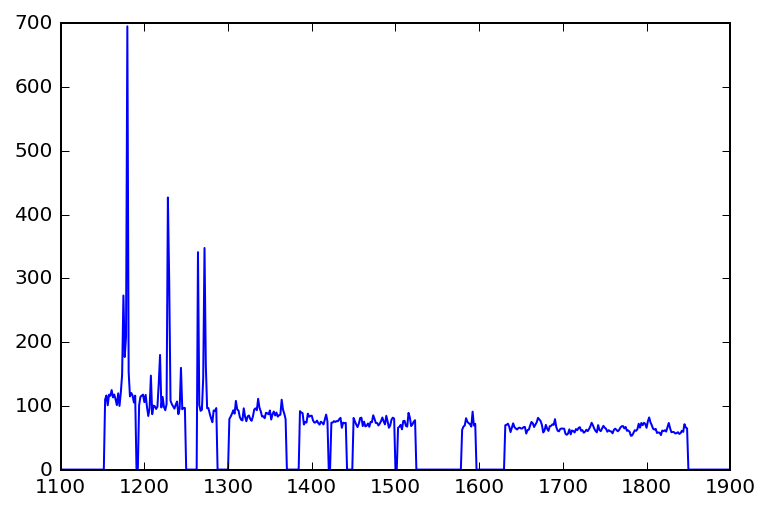

In [67]:
plt.plot((channel_edges[:-1]+channel_edges[1:])/2, 
         gtp_data[0].std(axis=1))

/misc/astron/archibald/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


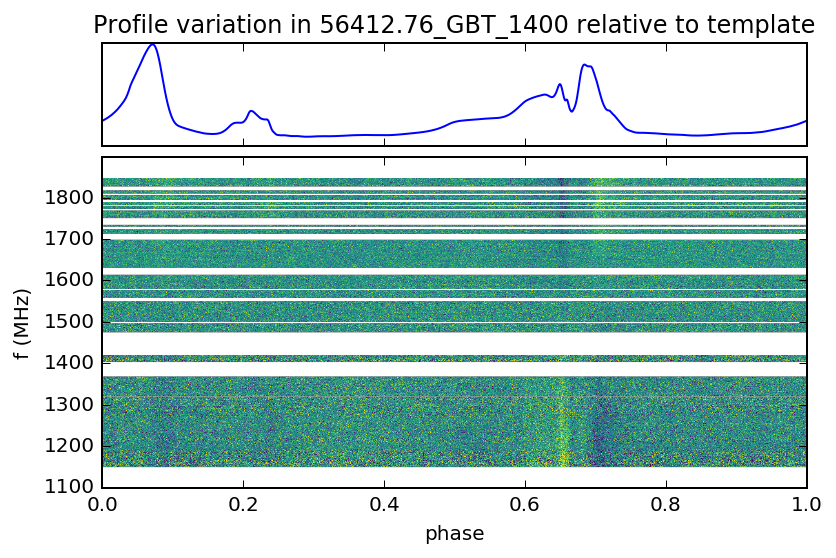

In [83]:
dprof = (gtp_data[0]*gtp_weights[:,None]).sum(axis=0)
phase = pipe.align_profile(t_values, dprof)
tz = pipe.rotate_phase(t_values,phase)
tz -= tz.mean()
tz /= np.sqrt(np.dot(tz,tz))

s = (gtp_data[0]*tz[None,:]).sum(axis=-1)
pd = gtp_data[0] - s[:,None]*tz[None,:]
pd /= s[:,None]
pd = np.ma.array(pd)
pd[gtp_weights<w_cut] = np.ma.masked

vmin, vmax = np.percentile(pd.compressed(), [1,99])

plt.subplot2grid((4,1),(1,0),rowspan=3)
plt.imshow(pd, 
           extent=(0,1,channel_edges[0],channel_edges[-1]),
           vmin=vmin, vmax=vmax)
plt.gca().set_aspect('auto')
plt.xlabel("phase")
plt.ylabel("f (MHz)")
plt.subplot2grid((4,1),(0,0))
plt.plot(t_phases, tz)
plt.gca().tick_params("both", left="off", labelleft="off", right="off", labelbottom="off")
plt.title("Profile variation in %s relative to template" % obsname)
#plt.gcf().set_size_inches(8,10)
plt.tight_layout(h_pad=0)
plt.savefig("profile-variation-gtp.pdf")